# Region Segmentation

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn
!pip install tqdm
!pip install pillow
!pip install torch
!pip install torchvision

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Traditional Segmentation Methods

def load_segmentation_dataset(images_dir, masks_dir, limit=None):
    """Load segmentation dataset"""
    images = []
    masks = []
    filenames = []

    # List all image files
    image_files = os.listdir(images_dir)
    if limit:
        image_files = image_files[:limit]

    for filename in tqdm(image_files, desc="Loading segmentation dataset"):
        # Load image
        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load corresponding mask
        mask_path = os.path.join(masks_dir, filename)
        if not os.path.exists(mask_path):
            continue
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply threshold to create binary mask
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Resize for consistency
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        images.append(img)
        masks.append(mask)
        filenames.append(filename)

    return np.array(images), np.array(masks), filenames

In [ ]:
# Load segmentation dataset
images, ground_truth_masks, filenames = load_segmentation_dataset(
    "dataset/images",
    "dataset/masks",
    limit=500# Limit for faster processing during development
)

Loading segmentation dataset: 100%|██████████| 500/500 [00:01<00:00, 333.69it/s]


In [ ]:
# Display some sample images and their masks
def display_samples(images, masks, num_samples=3):
    """Display sample images and their masks"""
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(images[i])
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f"Ground Truth Mask {i+1}")
        plt.axis('off')

        # Overlay mask on image
        plt.subplot(num_samples, 3, i*3+3)
        overlay = images[i].copy()
        overlay[masks[i] > 0] = (255, 0, 0)  # Red overlay
        plt.imshow(overlay)
        plt.title(f"Overlay {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

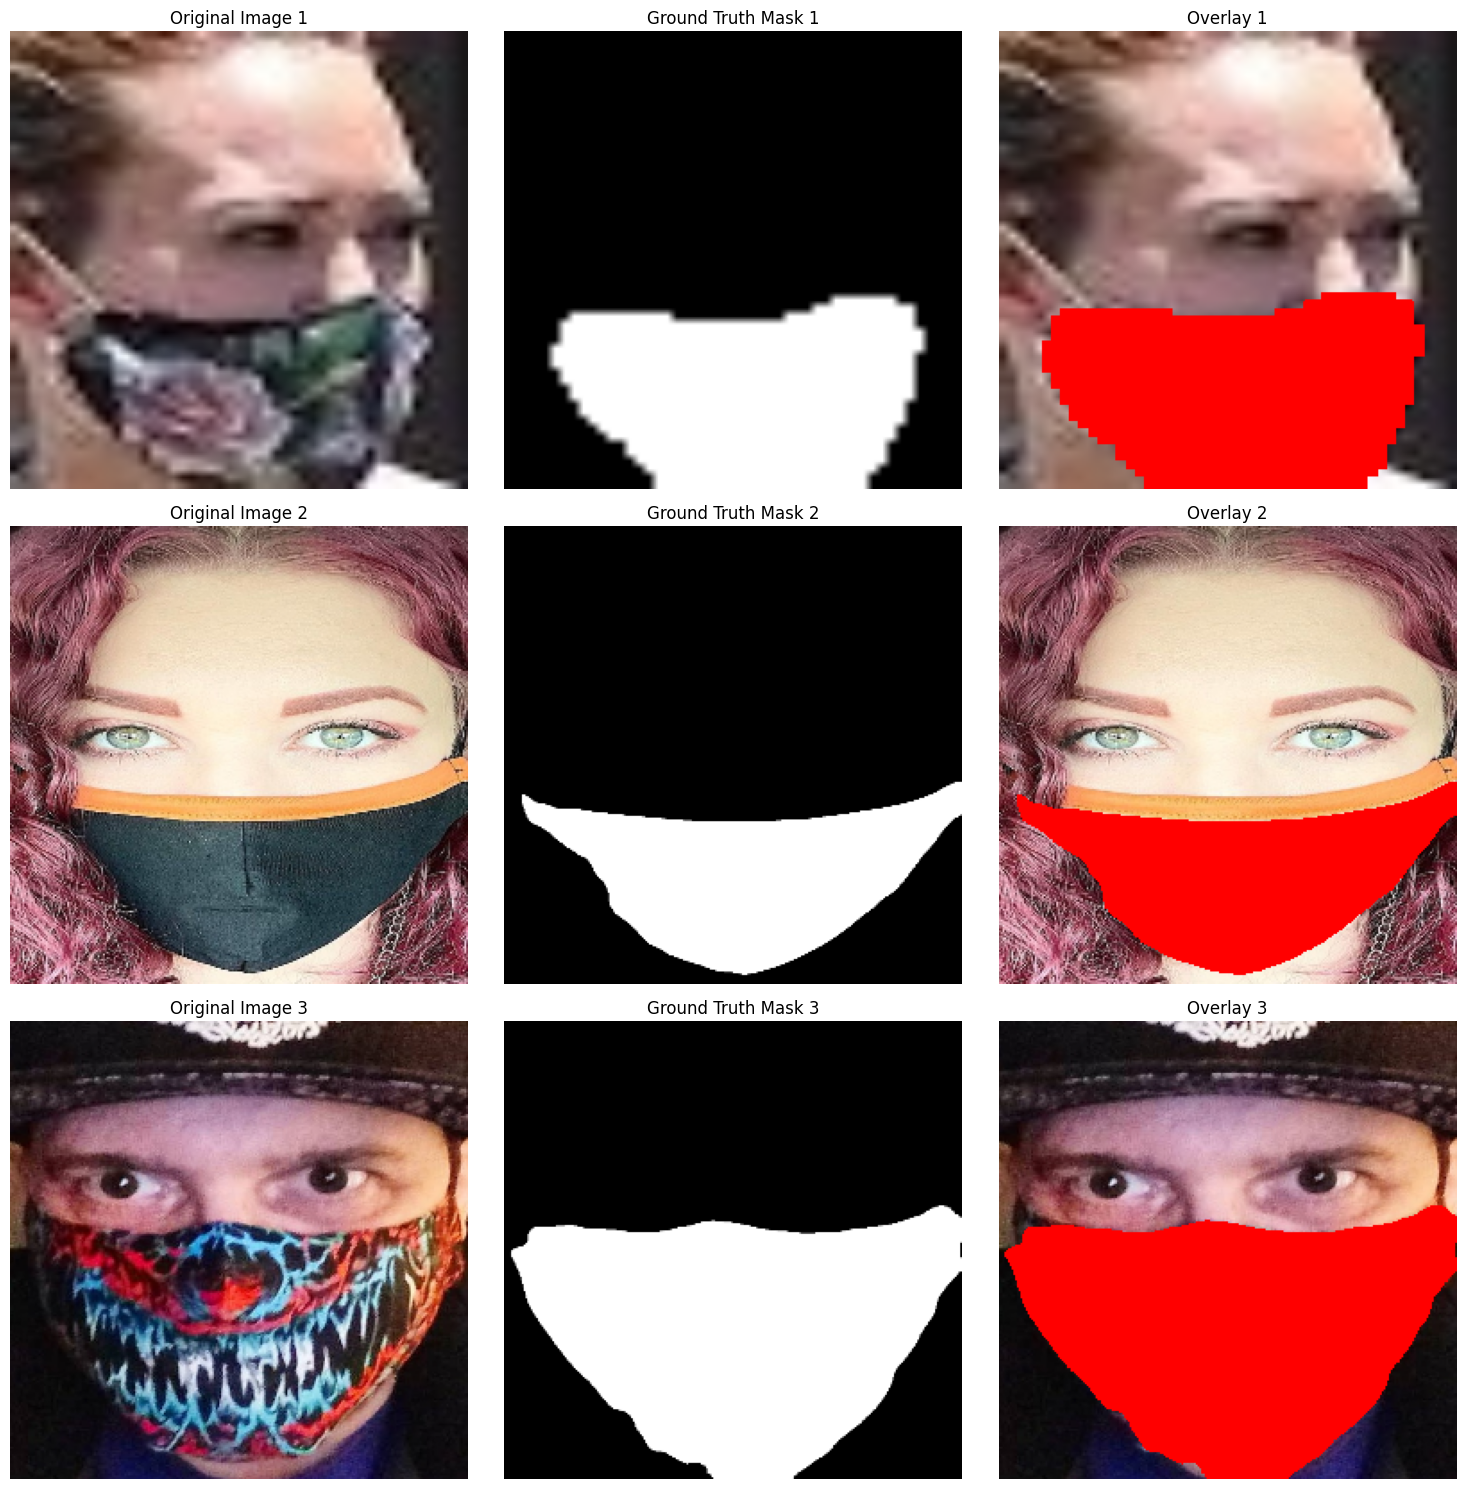

In [ ]:
# Show sample images and masks
display_samples(images, ground_truth_masks)

## Traditional Segmentation Methods

In [ ]:
def color_thresholding(image):
    """Segment mask using color thresholding"""
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define color range for face masks (typical blue/white masks)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 30, 255])

    # Create masks
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Combine masks
    combined_mask = cv2.bitwise_or(blue_mask, white_mask)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

    return combined_mask

In [ ]:
def edge_based_segmentation(image):
    """Segment mask using edge detection and contour finding"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detect edges using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate the edges to connect gaps
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask from contours
    mask = np.zeros_like(gray)

    # Filter contours based on area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:  # Filter out small contours
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Apply morphological operations to clean up
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

In [ ]:
def region_growing(image, seed_points=None):
    """Segment mask using region growing algorithm"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # If no seed points provided, use the center of the image
    if seed_points is None:
        h, w = gray.shape
        seed_points = [(w//2, h//2)]

    # Create mask
    mask = np.zeros_like(gray)

    # Define region growing parameters
    threshold = 10  # Intensity threshold

    # Process each seed point
    for seed in seed_points:
        x, y = seed
        seed_value = gray[y, x]

        # Initialize queue with seed point
        queue = [(x, y)]
        processed = set([(x, y)])

        while queue:
            curr_x, curr_y = queue.pop(0)
            mask[curr_y, curr_x] = 255

            # Check 8-connected neighbors
            neighbors = [
                (curr_x+1, curr_y), (curr_x-1, curr_y),
                (curr_x, curr_y+1), (curr_x, curr_y-1),
                (curr_x+1, curr_y+1), (curr_x-1, curr_y-1),
                (curr_x+1, curr_y-1), (curr_x-1, curr_y+1)
            ]

            for nx, ny in neighbors:
                # Check if within image bounds
                if 0 <= nx < gray.shape[1] and 0 <= ny < gray.shape[0]:
                    # Check if not processed and within threshold
                    if (nx, ny) not in processed and abs(int(gray[ny, nx]) - int(seed_value)) < threshold:
                        queue.append((nx, ny))
                        processed.add((nx, ny))

    # Apply morphological operations to clean up
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

In [ ]:
def watershed_segmentation(image):
    """Segment mask using watershed algorithm"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that background is not 0, but 1
    markers = markers + 1

    # Mark the unknown region with 0
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(image, markers)

    # Create mask: regions marked as 1 (background) are set to 0, others to 255
    mask = np.zeros_like(gray)
    mask[markers > 1] = 255

    # Clean up with morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

In [ ]:
# Apply traditional segmentation methods to dataset
def apply_segmentation_methods(images):
    """Apply different segmentation methods to images"""
    color_masks = []
    edge_masks = []
    watershed_masks = []
    region_growing_masks = []

    for img in tqdm(images, desc="Applying segmentation methods"):
        color_masks.append(color_thresholding(img))
        edge_masks.append(edge_based_segmentation(img))
        watershed_masks.append(watershed_segmentation(img))
        region_growing_masks.append(region_growing(img))

    return {
        'Color Thresholding': np.array(color_masks),
        'Edge-based': np.array(edge_masks),
        'Watershed': np.array(watershed_masks),
        'Region Growing': np.array(region_growing_masks)
    }

In [ ]:
# Calculate evaluation metrics
def calculate_metrics(pred_mask, gt_mask):
    """Calculate IoU and Dice score"""
    # Convert to binary
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    # Calculate IoU
    iou = intersection / union if union > 0 else 0

    # Calculate Dice score
    dice = (2 * intersection) / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) > 0 else 0

    return iou, dice

In [ ]:
# Evaluate traditional segmentation methods
def evaluate_segmentation_methods(segmented_masks, ground_truth_masks):
    """Evaluate traditional segmentation methods"""
    results = {}

    for method_name, pred_masks in segmented_masks.items():
        ious = []
        dice_scores = []

        for i in range(len(pred_masks)):
            iou, dice = calculate_metrics(pred_masks[i], ground_truth_masks[i])
            ious.append(iou)
            dice_scores.append(dice)

        results[method_name] = {
            'IoU': np.mean(ious),
            'Dice': np.mean(dice_scores)
        }

        print(f"{method_name} - Average IoU: {np.mean(ious):.4f}, Average Dice: {np.mean(dice_scores):.4f}")

    return results

In [ ]:
# Display segmentation results
def display_segmentation_results(images, ground_truth_masks, segmented_masks, indices, metrics):
    """Display segmentation results for selected images"""
    methods = list(segmented_masks.keys())
    num_methods = len(methods)
    num_images = len(indices)

    plt.figure(figsize=(15, 5 * num_images))

    for idx, image_idx in enumerate(indices):
        # Original image
        plt.subplot(num_images, num_methods + 2, idx * (num_methods + 2) + 1)
        plt.imshow(images[image_idx])
        plt.title(f"Original {image_idx}")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_images, num_methods + 2, idx * (num_methods + 2) + 2)
        plt.imshow(ground_truth_masks[image_idx], cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Segmentation results
        for method_idx, method_name in enumerate(methods):
            plt.subplot(num_images, num_methods + 2, idx * (num_methods + 2) + method_idx + 3)
            plt.imshow(segmented_masks[method_name][image_idx], cmap='gray')

            # Calculate metrics for this specific image
            iou, dice = calculate_metrics(segmented_masks[method_name][image_idx], ground_truth_masks[image_idx])
            plt.title(f"{method_name}\nIoU: {iou:.2f}, Dice: {dice:.2f}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Overall performance comparison
    plt.figure(figsize=(12, 6))

    # Plot IoU scores
    plt.subplot(1, 2, 1)
    plt.bar(metrics.keys(), [metrics[m]['IoU'] for m in metrics.keys()])
    plt.title('Average IoU Score')
    plt.ylim(0, 1)

    # Plot Dice scores
    plt.subplot(1, 2, 2)
    plt.bar(metrics.keys(), [metrics[m]['Dice'] for m in metrics.keys()])
    plt.title('Average Dice Score')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# Apply traditional segmentation methods
segmented_masks = apply_segmentation_methods(images)

Applying segmentation methods: 100%|██████████| 500/500 [00:11<00:00, 44.77it/s]


In [ ]:
# Evaluate methods
metrics = evaluate_segmentation_methods(segmented_masks, ground_truth_masks)

Color Thresholding - Average IoU: 0.2529, Average Dice: 0.3388
Edge-based - Average IoU: 0.2693, Average Dice: 0.3785
Watershed - Average IoU: 0.2143, Average Dice: 0.2703
Region Growing - Average IoU: 0.1013, Average Dice: 0.1473


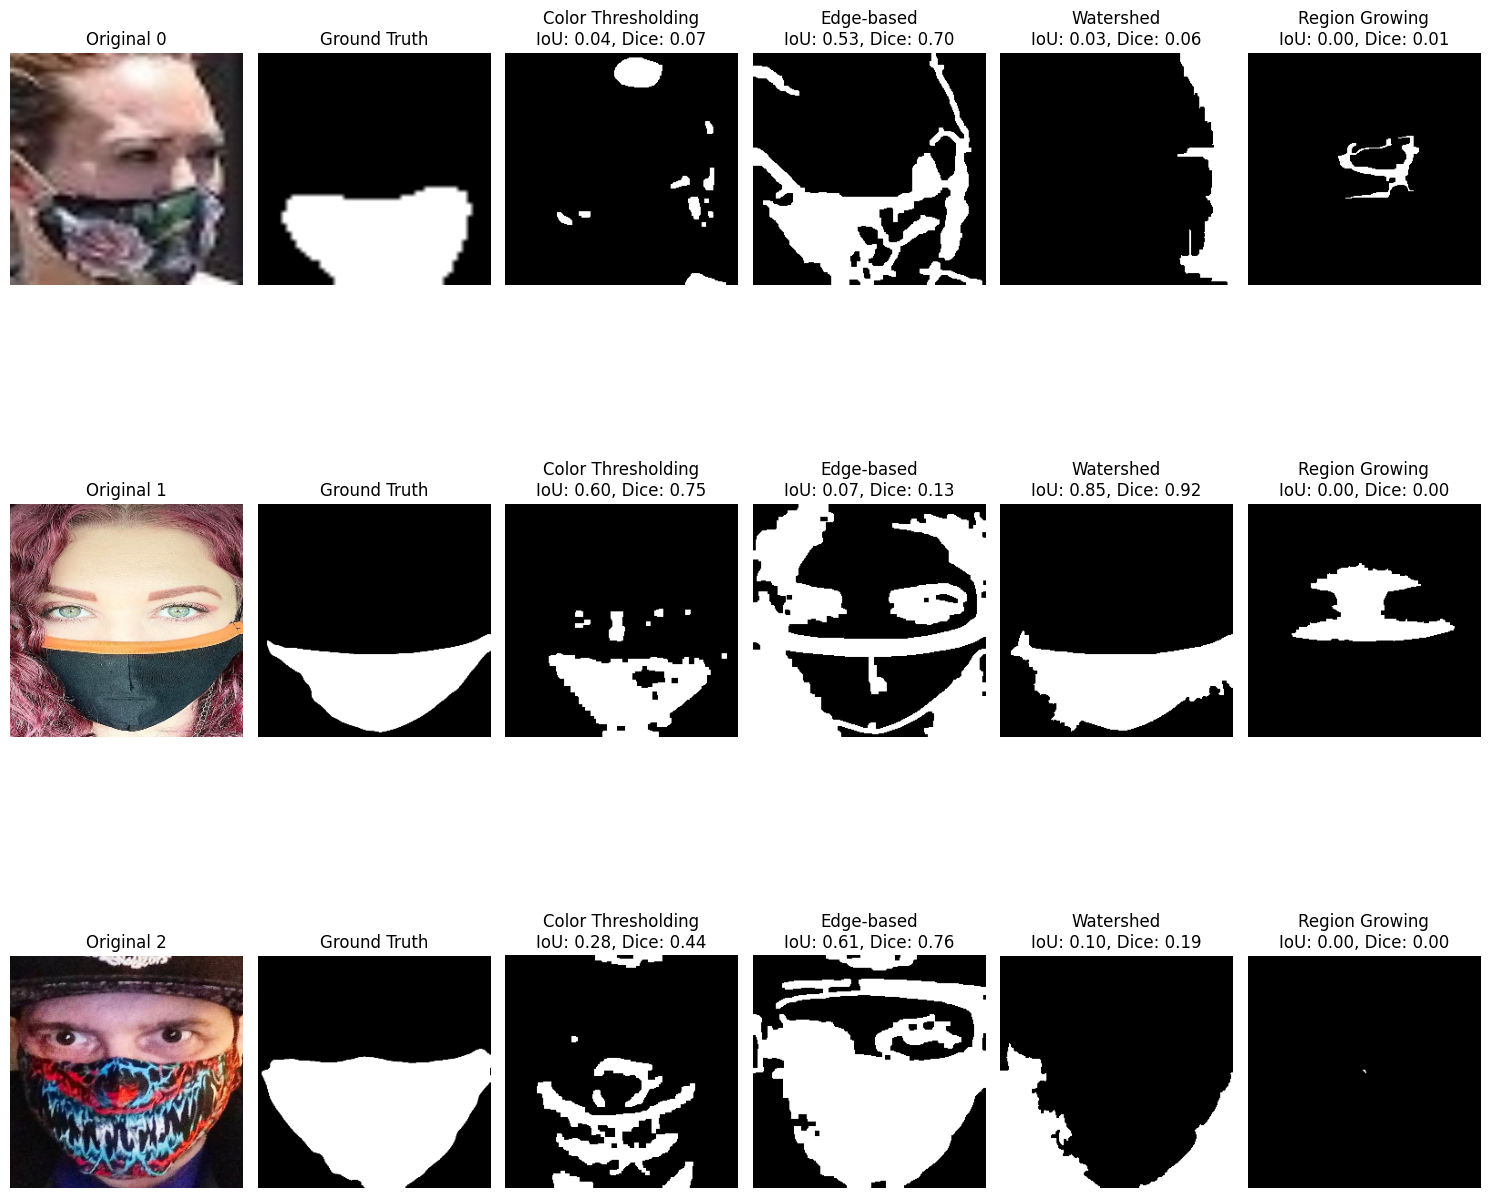

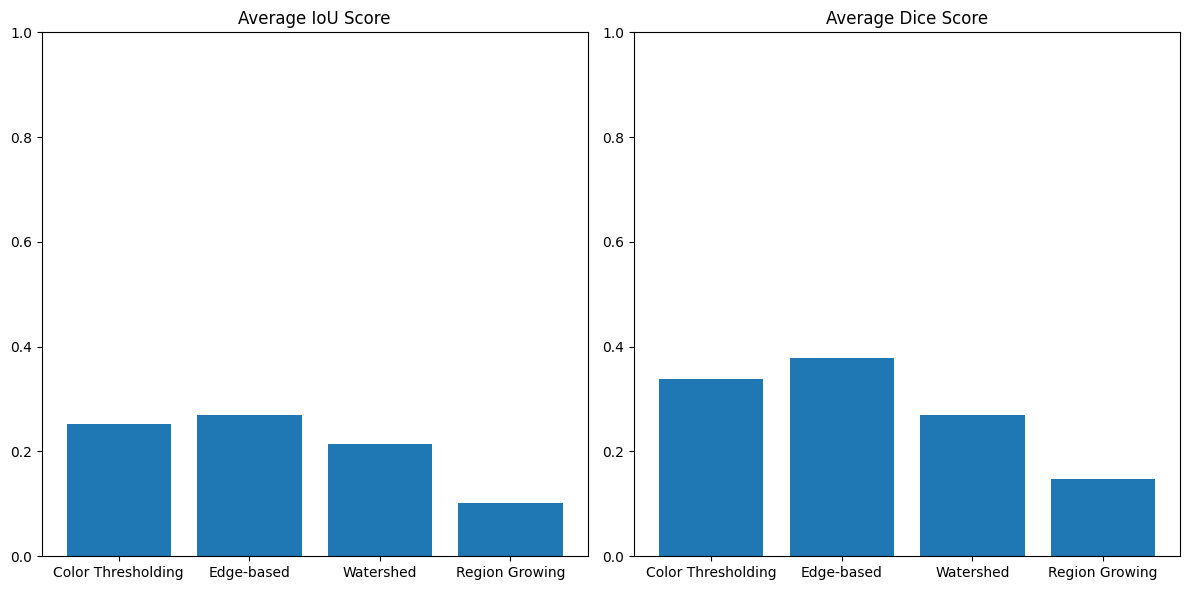

In [ ]:
# Display results for a few sample images
display_segmentation_results(images, ground_truth_masks, segmented_masks, [0, 1, 2], metrics)

## Mask Segmentation Using U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
# Define U-Net model
class DoubleConv(nn.Module):
    """Double convolution block for U-Net"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (upsampling)
        self.up_conv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)  # 512 + 512 = 1024 input channels after concat

        self.up_conv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)  # 256 + 256 = 512 input channels after concat

        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)  # 128 + 128 = 256 input channels after concat

        self.up_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)  # 64 + 64 = 128 input channels after concat

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder with skip connections
        dec4 = self.up_conv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.up_conv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.up_conv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up_conv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        # Final output
        out = self.final_conv(dec1)
        return torch.sigmoid(out)


In [ ]:
# Define segmentation dataset
class MaskSegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to PIL images for transforms
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)

            # For mask, we just want to convert to tensor
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()  # Binarize mask

        return image, mask

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, ground_truth_masks, test_size=0.2, random_state=42)

In [ ]:
# Create datasets
train_dataset = MaskSegmentationDataset(X_train, y_train, transform=transform)
test_dataset = MaskSegmentationDataset(X_test, y_test, transform=transform)

In [ ]:
# Create data loaders
batch_size = 4  # Smaller batch size due to U-Net's memory requirements
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Flatten predictions and targets
        logits = logits.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and union
        intersection = (logits * targets).sum()
        union = logits.sum() + targets.sum()

        # Calculate Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Return Dice loss
        return 1.0 - dice

In [ ]:
# Function to train U-Net model
def train_unet(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device="cpu"):
    model = model.to(device)

    # Training history
    train_losses = []
    test_losses = []
    test_ious = []
    test_dice_scores = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(device), masks.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Testing phase
        model.eval()
        running_loss = 0.0
        all_ious = []
        all_dice_scores = []

        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Testing"):
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                running_loss += loss.item() * images.size(0)

                # Convert predictions to binary masks
                pred_masks = (outputs > 0.5).float()

                # Calculate metrics for each image in batch
                for i in range(images.size(0)):
                    pred_mask_np = pred_masks[i, 0].cpu().numpy()
                    gt_mask_np = masks[i, 0].cpu().numpy()

                    iou, dice = calculate_metrics(pred_mask_np, gt_mask_np)
                    all_ious.append(iou)
                    all_dice_scores.append(dice)

        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        avg_iou = np.mean(all_ious)
        avg_dice = np.mean(all_dice_scores)
        test_ious.append(avg_iou)
        test_dice_scores.append(avg_dice)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
        print(f"Test IoU: {avg_iou:.4f}, Test Dice Score: {avg_dice:.4f}")

    return train_losses, test_losses, test_ious, test_dice_scores

In [ ]:
# Function to plot U-Net training history
def plot_unet_training_history(train_losses, test_losses, test_ious, test_dice_scores):
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot IoU
    plt.subplot(1, 3, 2)
    plt.plot(test_ious)
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Test IoU')

    # Plot Dice scores
    plt.subplot(1, 3, 3)
    plt.plot(test_dice_scores)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Test Dice Score')

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to visualize U-Net predictions
def visualize_unet_predictions(model, test_loader, device, num_samples=3):
    model.eval()

    # Get a batch from the test loader
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)

    # Make predictions
    with torch.no_grad():
        preds = model(images)
        preds = (preds > 0.5).float()

    # Convert to numpy arrays for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    denormalized_images = []
    for img in images:
        img = img.transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        denormalized_images.append(img)

    # Visualize predictions
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(min(num_samples, len(images))):
        # Original image
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(denormalized_images[i])
        plt.title("Original Image")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(masks[i, 0], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(preds[i, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Overlay prediction on image
        plt.subplot(num_samples, 4, i*4+4)
        overlay = denormalized_images[i].copy()
        overlay[preds[i, 0] > 0] = [1, 0, 0]  # Red overlay
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate and compare U-Net with traditional methods
def compare_segmentation_methods(unet_model, test_loader, traditional_methods_metrics, device):
    model = unet_model.to(device)
    model.eval()

    all_ious = []
    all_dice_scores = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating U-Net"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            pred_masks = (outputs > 0.5).float()

            # Calculate metrics for each image in batch
            for i in range(images.size(0)):
                pred_mask_np = pred_masks[i, 0].cpu().numpy()
                gt_mask_np = masks[i, 0].cpu().numpy()

                iou, dice = calculate_metrics(pred_mask_np, gt_mask_np)
                all_ious.append(iou)
                all_dice_scores.append(dice)

    unet_metrics = {
        'IoU': np.mean(all_ious),
        'Dice': np.mean(all_dice_scores)
    }

    print(f"U-Net - Average IoU: {unet_metrics['IoU']:.4f}, Average Dice: {unet_metrics['Dice']:.4f}")

    # Combine metrics for comparison
    all_metrics = traditional_methods_metrics.copy()
    all_metrics['U-Net'] = unet_metrics

    # Plot comparison
    plt.figure(figsize=(12, 6))

    # Plot IoU scores
    plt.subplot(1, 2, 1)
    plt.bar(all_metrics.keys(), [all_metrics[m]['IoU'] for m in all_metrics.keys()])
    plt.title('Average IoU Score')
    plt.ylim(0, 1)

    # Plot Dice scores
    plt.subplot(1, 2, 2)
    plt.bar(all_metrics.keys(), [all_metrics[m]['Dice'] for m in all_metrics.keys()])
    plt.title('Average Dice Score')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return all_metrics

In [ ]:
# Initialize U-Net model
unet_model = UNet(in_channels=3, out_channels=1)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Define loss function and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

In [ ]:
# Train U-Net model
num_epochs = 10
train_losses, test_losses, test_ious, test_dice_scores = train_unet(
    unet_model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

Epoch 1/10 - Testing: 100%|█████████████████████| 25/25 [01:35<00:00,  3.80s/it]


Epoch 1/10
Train Loss: 0.3695, Test Loss: 0.2722
Test IoU: 0.5926, Test Dice Score: 0.7270


Epoch 2/10 - Testing: 100%|█████████████████████| 25/25 [01:36<00:00,  3.86s/it]


Epoch 2/10
Train Loss: 0.2449, Test Loss: 0.2772
Test IoU: 0.5903, Test Dice Score: 0.6992


Epoch 3/10 - Testing: 100%|█████████████████████| 25/25 [01:41<00:00,  4.06s/it]


Epoch 3/10
Train Loss: 0.1972, Test Loss: 0.2176
Test IoU: 0.6541, Test Dice Score: 0.7644


Epoch 4/10 - Testing: 100%|█████████████████████| 25/25 [01:36<00:00,  3.86s/it]


Epoch 4/10
Train Loss: 0.1932, Test Loss: 0.2041
Test IoU: 0.6768, Test Dice Score: 0.7805


Epoch 5/10 - Testing: 100%|█████████████████████| 25/25 [01:37<00:00,  3.88s/it]


Epoch 5/10
Train Loss: 0.1707, Test Loss: 0.1637
Test IoU: 0.7203, Test Dice Score: 0.8215


Epoch 6/10 - Testing: 100%|█████████████████████| 25/25 [01:37<00:00,  3.89s/it]


Epoch 6/10
Train Loss: 0.1616, Test Loss: 0.1463
Test IoU: 0.7513, Test Dice Score: 0.8502


Epoch 7/10 - Testing: 100%|█████████████████████| 25/25 [01:34<00:00,  3.78s/it]


Epoch 7/10
Train Loss: 0.1464, Test Loss: 0.1361
Test IoU: 0.7671, Test Dice Score: 0.8607


Epoch 8/10 - Testing: 100%|█████████████████████| 25/25 [01:35<00:00,  3.81s/it]


Epoch 8/10
Train Loss: 0.1473, Test Loss: 0.1235
Test IoU: 0.7834, Test Dice Score: 0.8721


Epoch 9/10 - Testing: 100%|█████████████████████| 25/25 [01:32<00:00,  3.70s/it]


Epoch 9/10
Train Loss: 0.1303, Test Loss: 0.1431
Test IoU: 0.7602, Test Dice Score: 0.8510


Epoch 10/10 - Testing: 100%|████████████████████| 25/25 [01:30<00:00,  3.63s/it]

Epoch 10/10
Train Loss: 0.1296, Test Loss: 0.1241
Test IoU: 0.7818, Test Dice Score: 0.8696


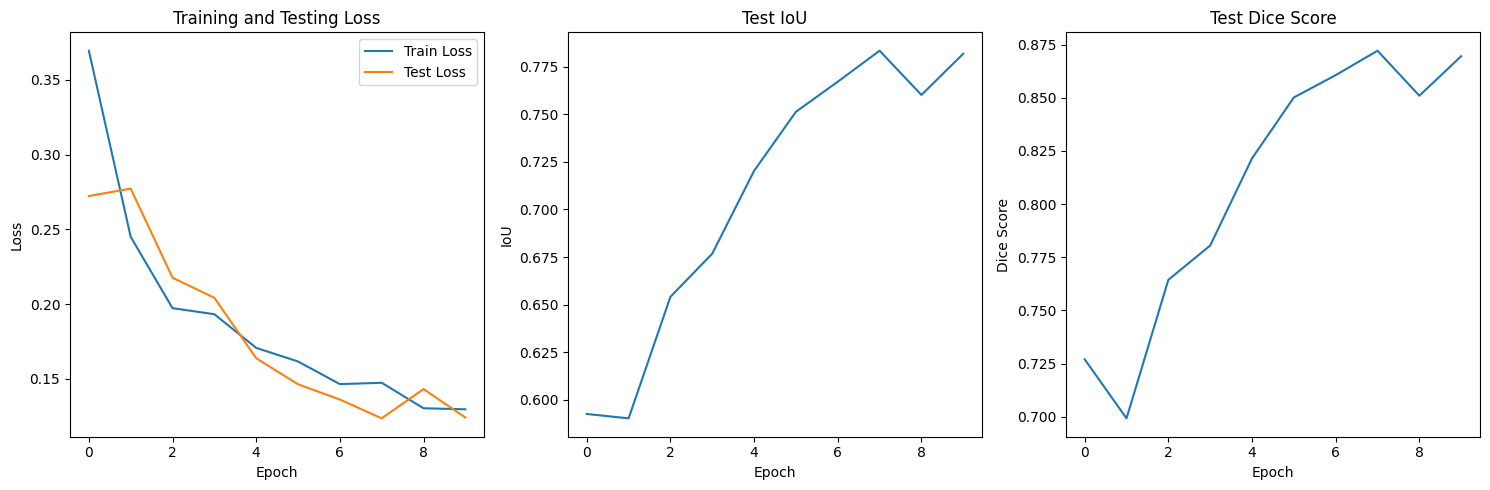

In [ ]:
# Plot training history
plot_unet_training_history(train_losses, test_losses, test_ious, test_dice_scores)

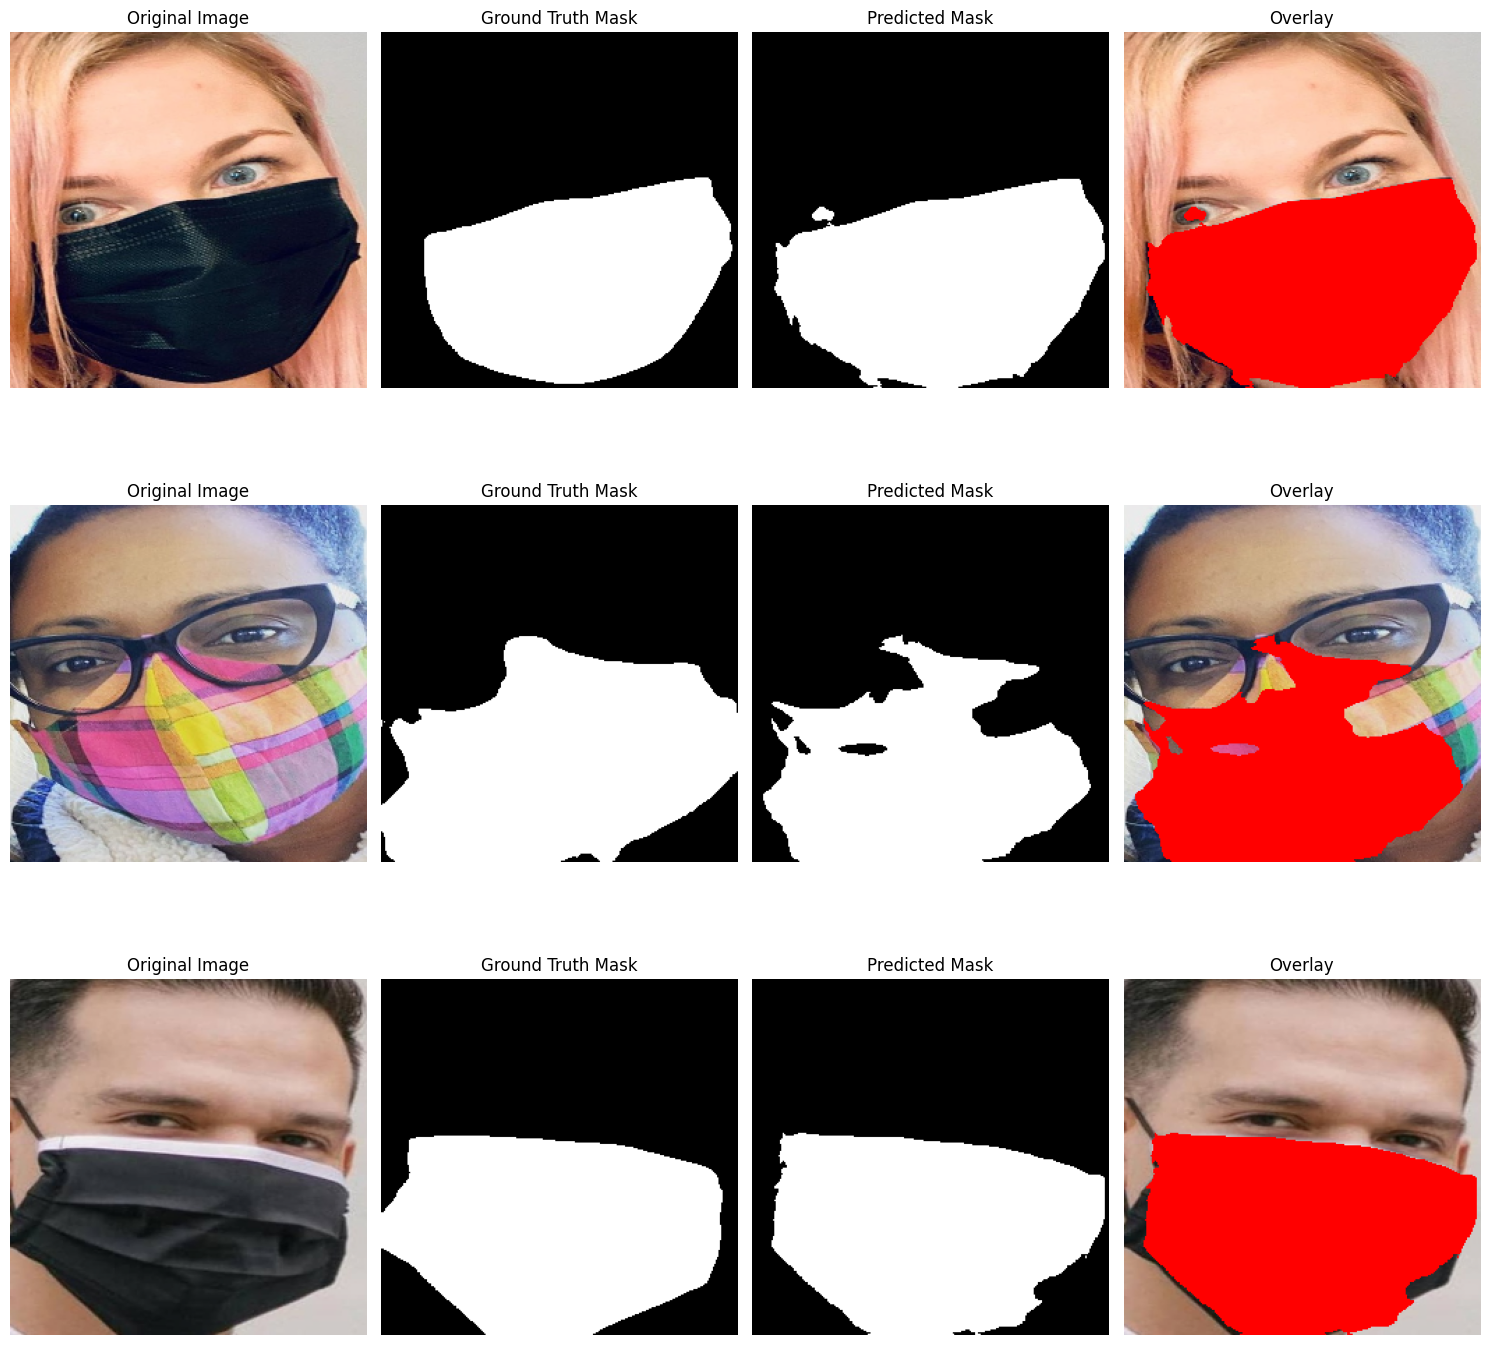

In [ ]:
# Visualize U-Net predictions
visualize_unet_predictions(unet_model, test_loader, device)

Evaluating U-Net: 100%|█████████████████████████| 25/25 [01:31<00:00,  3.66s/it]


U-Net - Average IoU: 0.7818, Average Dice: 0.8696


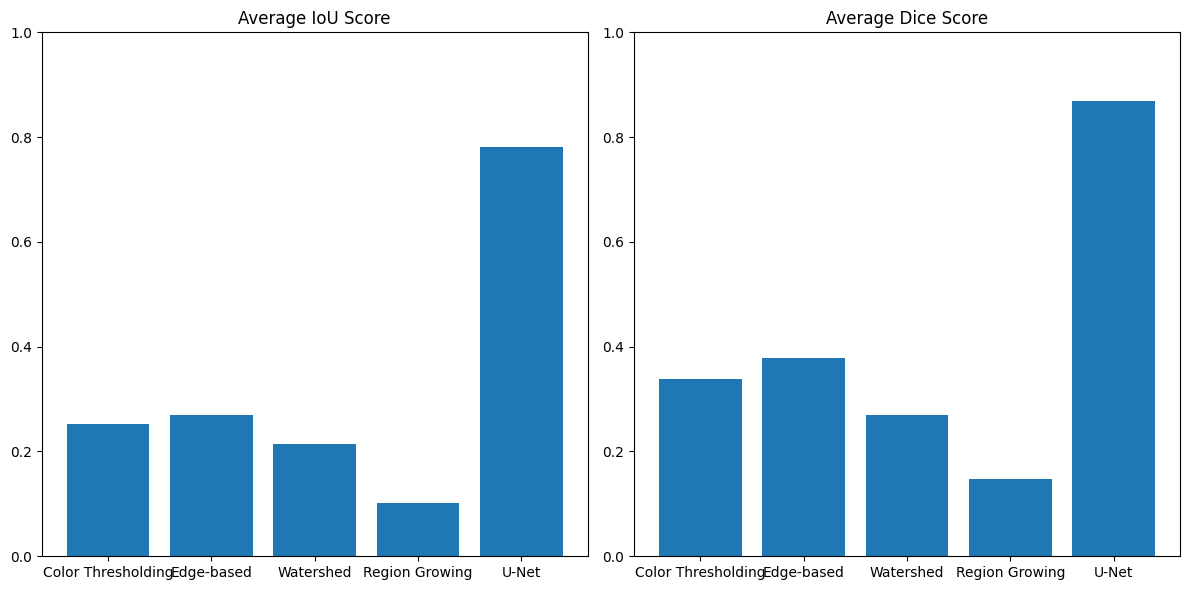

In [ ]:
# Compare U-Net with traditional methods
all_metrics = compare_segmentation_methods(unet_model, test_loader, metrics, device)

In [ ]:
# Save U-Net model
torch.save(unet_model.state_dict(), 'unet_face_mask_model.pth')

In [ ]:
# Print final comparison results
print("\nFinal Segmentation Performance Comparison:")
for method, scores in all_metrics.items():
    print(f"{method} - IoU: {scores['IoU']:.4f}, Dice: {scores['Dice']:.4f}")


Final Segmentation Performance Comparison:
Color Thresholding - IoU: 0.2529, Dice: 0.3388
Edge-based - IoU: 0.2693, Dice: 0.3785
Watershed - IoU: 0.2143, Dice: 0.2703
Region Growing - IoU: 0.1013, Dice: 0.1473
U-Net - IoU: 0.7818, Dice: 0.8696
